# Project one Final Notebook 

First We import common packages that are being used throughout the project

In [1]:
#Importing packages
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd

# Functions being used throughout the project.

In [2]:
#creating the model based on feature matrix and optimal beta coeficients
def betaAndYtildeGenerator(X_train,y_train):
    beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
    ytilde = X_train @ beta
    return beta,ytilde


In [3]:
#Setting up the Feature matrix
def X_generator(x_data, y_data, n_polydegree ):
    if len(x_data.shape) > 1:
        x_data = np.ravel(x_data)
        y_data = np.ravel(y_data)

    N = len(x_data)
    l = int((n_polydegree+1)*(n_polydegree+2)/2)  # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n_polydegree+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x_data**(i-k))*(y_data**k)

    return X


In [4]:
# split in training and test data
def traningDataGenerator(X,z):
    X_train, X_test, y_train, y_test = train_test_split(X,z,test_size=0.2, random_state= 11)
    return X_train, X_test, y_train, y_test

In [5]:
#Functions for R2 and MSE
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [6]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [7]:
#Function for generating noise
def noiseGeneration(z_input, scaling = 1):
    
    nosyZ= z_input + np.random.randn(*z_input.shape) * scaling
    return nosyZ

In [8]:
#Fuction for making x and y of given size
def makeData(n_size=20):
    x = np.sort(np.random.uniform(0, 1, n_size))
    y = np.sort(np.random.uniform(0, 1, n_size))
    x_mesh, y_mesh = np.meshgrid(x,y)
    x_flat = np.ravel(x_mesh) 
    y_flat = np.ravel(y_mesh)
    return x_flat,y_flat

In [9]:
#Scaling function for the feature matrix
def scale(X_train,X_test,y_train,y_test):
    scaler = StandardScaler(with_std=True)
    scaler_x = scaler.fit(X_train) # Scaling x-data
    X_train_scaled = scaler_x.transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    
    
    #scaler_y = np.mean(y_train)
    #y_train_scaled = y_train - scaler_y
    #y_test_scaled = y_test - scaler_y
    scaler_y = scaler.fit(y_train.reshape(-1,1))
    y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()
    return X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled

In [22]:
#Function to plot z the franke funcion
def plot_z(x,y,z,title):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x_mesh, y_mesh, z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title("{}".format(title))
    plt.show()

In [11]:
#Ridge and lasso as a function of lambda, finding best lambda value given a polynomial
def RidgeAndLasso(X_train_local,z_train_local,X_test_local,z_test_local,numOfPoly_max):
    import warnings
    warnings.filterwarnings('ignore') #dont question my authority
    poly_degree = int((numOfPoly_max+1)*(numOfPoly_max+2)/2)
    numberOfLambdas = 100 #number of lamdas
    lambdas = np.logspace(-4, 4, numberOfLambdas)
    MSERidgePredict = np.zeros(numberOfLambdas)
    MSELassoPredict = np.zeros(numberOfLambdas)
    I = np.eye(poly_degree,poly_degree) #need to fix dimensions
    if poly>0:
        I = np.eye(poly_degree-1,poly_degree-1) #need to fix dimensions
    RidgeBestLambdaIndex = 0 #default value
    LassoBestLambdaIndex = 0 #default value
    for i in range(numberOfLambdas):
        lmb = lambdas[i]
        Ridge_beta = np.linalg.pinv(X_train_local.T @ X_train_local + lmb*I) @ X_train_local.T @ z_train_local
        z_intercept = np.mean(z_train_local,axis = 0)
        # and then make the prediction
        ypredictRidge = X_test_local @ Ridge_beta + z_intercept
        MSERidgePredict[i] = MSE(z_test_local,ypredictRidge)
        RegLasso = linear_model.Lasso(lmb,fit_intercept=True)
        RegLasso.fit(X_train_local,z_train_local)
        ypredictLasso = RegLasso.predict(X_test_local)
        MSELassoPredict[i] = MSE(z_test_local,ypredictLasso)
        if i==0:
            RidgeBestLambdaIndex = 0
            LassoBestLambdaIndex = 0

        else :
            if MSERidgePredict[i] < MSERidgePredict[RidgeBestLambdaIndex] :
                RidgeBestLambdaIndex = i
            if MSELassoPredict[i] < MSELassoPredict[LassoBestLambdaIndex] :
                LassoBestLambdaIndex = i
    return lambdas[LassoBestLambdaIndex], lambdas[RidgeBestLambdaIndex]#, MSERidgePredict, MSELassoPredict

# Task a/b of project one  Fitting a polynomial to the Franke function

The code below fits the franke function to a polynomial of 5 made on a mesh grid from x and y data (20x20)
It is running for scaled and unscaled data simutaniusly for comparing and providing arguments for or agains scaling this data.

In [12]:
arr = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
print(arr.shape)
arr = np.delete(arr, 0, 1)
print(arr.shape)


(3, 4)
(3, 3)


C:\Users\Lasse\AppData\Local\Temp/ipykernel_23312/361316503.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


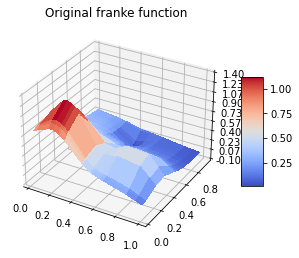

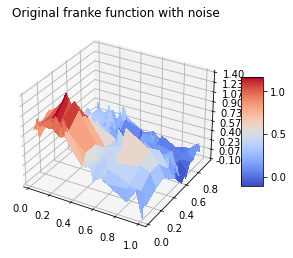

degree : 0
Training R2 of degree 0: 
 0.0
Training MSE of degree 0: 
 0.07242331998747473
Test R2 of degree 0: 
 -0.009338074810836039
Test MSE of degree 0: 
 0.08049996464176871
Training R2_scaled of degree 0: 
 1.0000000000000004
Test MSE_scaled of degree 0: 
 1.1115199448974558
Training MSE_scaled of degree 0: 
 1.0000000000000004
Test MSE_scaled of degree 0: 
 1.1115199448974558


C:\Users\Lasse\AppData\Local\Temp/ipykernel_23312/361316503.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


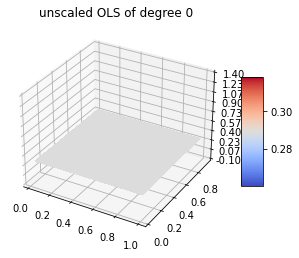

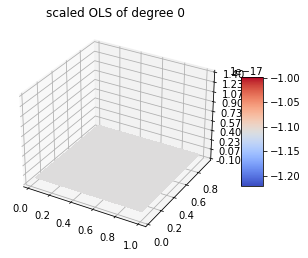

degree : 1
Training R2 of degree 1: 
 0.6161529700030428
Training MSE of degree 1: 
 0.027799476279711445
Test R2 of degree 1: 
 0.5951843126483042
Test MSE of degree 1: 
 0.03228615795986116
Training R2_scaled of degree 1: 
 0.3838470299969573
Test MSE_scaled of degree 1: 
 0.44579781713189703
Training MSE_scaled of degree 1: 
 0.3838470299969573
Test MSE_scaled of degree 1: 
 0.44579781713189703


C:\Users\Lasse\AppData\Local\Temp/ipykernel_23312/361316503.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


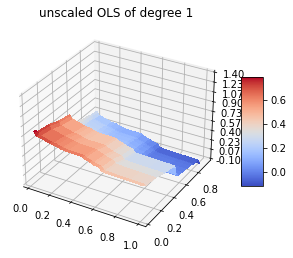

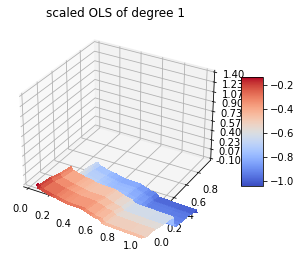

degree : 2
Training R2 of degree 2: 
 0.7150184573082539
Training MSE of degree 2: 
 0.02063930945688853
Test R2 of degree 2: 
 0.7521938879907917
Test MSE of degree 2: 
 0.019763827158203705
Training R2_scaled of degree 2: 
 0.28498154269174625
Test MSE_scaled of degree 2: 
 0.272893139414527
Training MSE_scaled of degree 2: 
 0.28498154269174625
Test MSE_scaled of degree 2: 
 0.272893139414527


C:\Users\Lasse\AppData\Local\Temp/ipykernel_23312/361316503.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


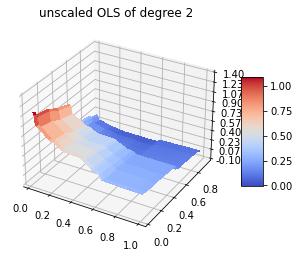

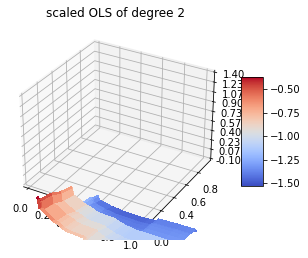

degree : 3
Training R2 of degree 3: 
 0.8105131445480227
Training MSE of degree 3: 
 0.013723267165818925
Test R2 of degree 3: 
 0.8160843151480919
Test MSE of degree 3: 
 0.01466823306989582
Training R2_scaled of degree 3: 
 0.18948685545197733
Test MSE_scaled of degree 3: 
 0.20253466801066883
Training MSE_scaled of degree 3: 
 0.18948685545197733
Test MSE_scaled of degree 3: 
 0.20253466801066883


C:\Users\Lasse\AppData\Local\Temp/ipykernel_23312/361316503.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


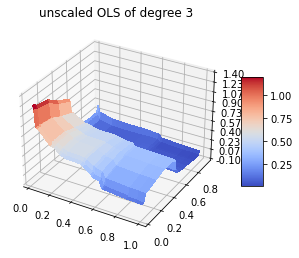

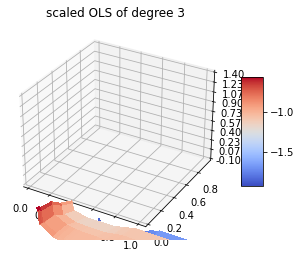

degree : 4
Training R2 of degree 4: 
 0.8277342629157572
Training MSE of degree 4: 
 0.012476056599730303
Test R2 of degree 4: 
 0.8060426279026727
Test MSE of degree 4: 
 0.015469109890431343
Training R2_scaled of degree 4: 
 0.17226573708424237
Test MSE_scaled of degree 4: 
 0.21359294067057516
Training MSE_scaled of degree 4: 
 0.17226573708424237
Test MSE_scaled of degree 4: 
 0.21359294067057516


C:\Users\Lasse\AppData\Local\Temp/ipykernel_23312/361316503.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


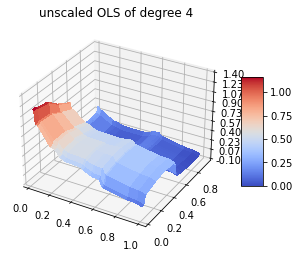

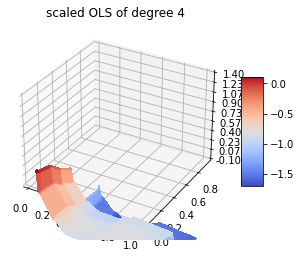

degree : 5
Training R2 of degree 5: 
 0.8563531335401775
Training MSE of degree 5: 
 0.010403382974817776
Test R2 of degree 5: 
 0.8246902025728491
Test MSE of degree 5: 
 0.013981868757785787
Training R2_scaled of degree 5: 
 0.14364686645982233
Test MSE_scaled of degree 5: 
 0.19305755016627285
Training MSE_scaled of degree 5: 
 0.14364686645982233
Test MSE_scaled of degree 5: 
 0.19305755016627285


C:\Users\Lasse\AppData\Local\Temp/ipykernel_23312/361316503.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


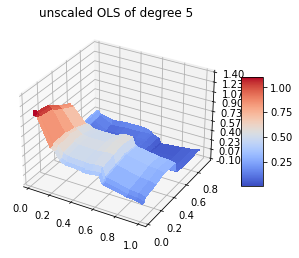

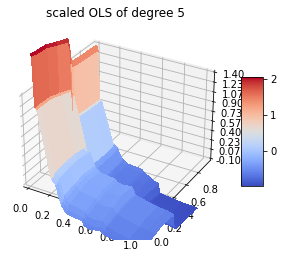

Test MSE of degree 5: 
 0.013981868757785787
Test MSE_scaled of degree 5: 
 0.19305755016627285
6


In [27]:

np.random.seed(870)

#"plotting data settup"
N = 20 #data size
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y) #used for plotting
z_mesh = FrankeFunction(x_mesh,y_mesh)
z_mesh_noisy = noiseGeneration(z_mesh,0.1)
plot_z(x_mesh,y_mesh,z_mesh,"Original franke function")
plot_z(x_mesh,y_mesh,z_mesh_noisy,"Original franke function with noise")
plot_out = True #change to false to not include 3d plots of franke function from regression

#regression data setup
x_flat,y_flat = makeData(N) # used for regresion
z_in = FrankeFunction(x_flat, y_flat)
z = noiseGeneration(z_in,0.1)

print_out =True
#creating lists
R2_test = []
R2_train = []
R2_test_scaled = []
R2_train_scaled = []
MSE_test = []
MSE_train = []
MSE_test_scaled = []
MSE_train_scaled = []
numOfPoly_index = []
beta_index = []
beta_index_scaled = []
numOfPoly_max = 5
#for loop for number of polynomials
for i in range(numOfPoly_max +1 ):
    
    numOfPoly = i 
    poly = i
    X = X_generator(x_flat,y_flat, numOfPoly)
    Xs = X_generator(x_flat,y_flat, numOfPoly)
    if i > 0:
        Xs = np.delete(Xs,0,1)
        
        
    X_train, X_test, z_train, z_test = traningDataGenerator(X,z)
    X_train_s, X_test_s, z_train_s, z_test_s = traningDataGenerator(Xs,z)
    X_offset = np.mean(X_train,axis=0)
    z_offset = np.mean(z_train,axis=0)
    
    #scaling the data
    X_train_scaled, X_test_scaled, z_train_scaled, z_test_scaled = scale(X_train_s, X_test_s ,z_train_s, z_test_s)
    X_offset_scaled = np.mean(X_train_scaled,axis=0)
    z_offset_scaled = np.mean(z_train_scaled,axis=0)
    # matrix inversion to find beta
    beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
    intercept = np.mean(z_offset - X_offset @ beta)
    beta_scaled = np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ z_train_scaled #scaled
    intercept_scaled = np.mean(z_offset_scaled - X_offset_scaled @ beta_scaled)
    
    # and then make the prediction
    
    ztilde = X_train @ beta 
    ztilde_scaled = X_train_scaled @ beta_scaled + z_offset_scaled #scaled
    zpredict = X_test @ beta 
    zpredict_scaled = X_test_scaled @ beta_scaled + z_offset_scaled  #scaled
    
    R2_test.append(R2(z_test,zpredict))
    R2_test_scaled.append(R2(z_test_scaled,zpredict_scaled)) #scaled
    
    R2_train.append(R2(z_train,ztilde))
    R2_train_scaled.append(R2(z_train_scaled,ztilde_scaled)) #scaled
    
    MSE_train.append(MSE(z_train,ztilde))
    MSE_train_scaled.append(MSE(z_train_scaled,ztilde_scaled)) #scaled
    
    MSE_test.append(MSE(z_test,zpredict))
    MSE_test_scaled.append(MSE(z_test_scaled,zpredict_scaled)) #scaled
    
    numOfPoly_index.append(numOfPoly)
    beta_index.append(beta)
    beta_index_scaled.append(beta_scaled) #scaled
     

        
    #Printing each itteration
    if (print_out == True):
        print("degree : {}".format(poly))
        print("Training R2 of degree {}: \n".format(numOfPoly),R2(z_train,ztilde))
        print("Training MSE of degree {}: \n".format(numOfPoly),MSE(z_train,ztilde))
        print("Test R2 of degree {}: \n".format(numOfPoly),R2(z_test,zpredict))
        print("Test MSE of degree {}: \n".format(numOfPoly),MSE(z_test,zpredict))
        print("Training R2_scaled of degree {}: \n".format(numOfPoly),MSE(z_train_scaled,ztilde_scaled))
        print("Test MSE_scaled of degree {}: \n".format(numOfPoly),MSE(z_test_scaled,zpredict_scaled))
        print("Training MSE_scaled of degree {}: \n".format(numOfPoly),MSE(z_train_scaled,ztilde_scaled))
        print("Test MSE_scaled of degree {}: \n".format(numOfPoly),MSE(z_test_scaled,zpredict_scaled))
    if plot_out ==True:
        z_plot_unscaled = X @ beta
        z_plot_scaled = Xs @ beta_scaled + intercept_scaled
        z_plot_unscaled = z_plot_unscaled.reshape(z_mesh.shape)
        z_plot_scaled = z_plot_scaled.reshape(z_mesh.shape)
        plot_z(x_mesh,y_mesh,z_plot_unscaled,"unscaled OLS of degree {}".format(i))
        plot_z(x_mesh,y_mesh,z_plot_scaled,"scaled OLS of degree {}".format(i))
    
    
 



print("Test MSE of degree {}: \n".format(numOfPoly),MSE(z_test,zpredict))
print("Test MSE_scaled of degree {}: \n".format(numOfPoly),MSE(z_test_scaled,zpredict_scaled))

print(len(numOfPoly_index))

Suprised to see that the scaling on this data set does not contribute to much, on 20x20 mesh grid. running with more datapoint contributes to training and test data converges into one another as expected since more data leads to a better model. And increasing the polynomial degree causes the test MSE scaled to be worse than the unscaled. Although below it can be observed that the unscaled and scaled case behave simulary. As expected to see the Test MSE gets better with each grade of complexity added up until 5 degrees.


<Figure size 720x432 with 0 Axes>

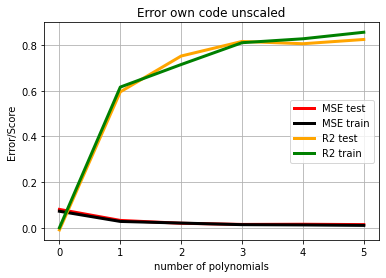

In [28]:
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
ax.set_xlabel('number of polynomials')
ax.set_ylabel('Error/Score',color ="black")
ax.plot(numOfPoly_index,MSE_test ,  label='MSE test',linewidth=3.0, c= "red")
ax.plot(numOfPoly_index,MSE_train ,label="MSE train",linewidth=3.0, c= "black")
ax.plot(numOfPoly_index,R2_test ,  label='R2 test',linewidth=3.0, c= "orange")
ax.plot(numOfPoly_index,R2_train ,label="R2 train",linewidth=3.0, c= "green")
plt.title("Error own code unscaled")
plt.grid()

leg = ax.legend();

As a mather of fact the scaling of the datasett. makes the MSE worse.

<Figure size 720x432 with 0 Axes>

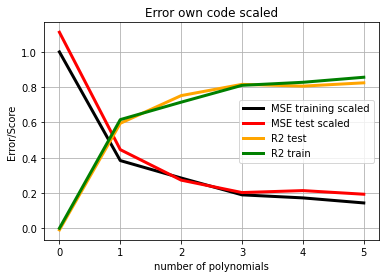

In [29]:
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
ax.set_xlabel('number of polynomials')
ax.set_ylabel('Error/Score',color ="black")
ax.plot(numOfPoly_index,MSE_train_scaled ,  label='MSE training scaled',linewidth=3.0, c= "black")
ax.plot(numOfPoly_index,MSE_test_scaled ,label="MSE test scaled",linewidth=3.0, c= "red")
ax.plot(numOfPoly_index,R2_test_scaled ,  label='R2 test',linewidth=3.0, c= "orange")
ax.plot(numOfPoly_index,R2_train_scaled ,label="R2 train",linewidth=3.0, c= "green")
ax.set_title('Error own code scaled')
plt.grid()

leg = ax.legend();

The Code below gives a plot of the confidence intervvals of the beta coeficients both scaled and unscaled
In the report under chapter 2 (expectation and variance) you can read about the variance of beta and its expectation value. This can be used to plot the confidence interval of beta.

$$Confidence of beta = \mu_{\beta}\pm \frac{2\sigma_{\beta}}{\sqrt{n}}$$

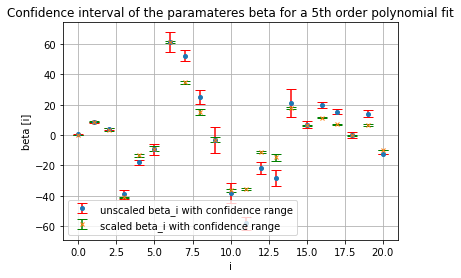

In [16]:
_PH_unscaled = len(beta) 
_PH_scaled = len(beta_scaled) 
variance_s = np.zeros(_PH_scaled +1)
CI_s = np.zeros(_PH_scaled +1)
variance = np.zeros(_PH_unscaled)
CI = np.zeros(_PH_unscaled )

for i in range(_PH_scaled ):
    variance[i] = 0.1**2 * np.linalg.pinv(X_train.T @ X_train)[i,i]
    CI[i] = 2*np.sqrt(variance[i])/np.sqrt(N)
    variance_s[i] = 0.1**2 * np.linalg.pinv(X_train_scaled.T @ X_train_scaled)[i,i]
    CI_s[i] = 2*np.sqrt(variance_s[i])/np.sqrt(N)

print("")
plt.errorbar(np.arange(0,_PH_unscaled), beta, yerr=CI, fmt='o', ecolor='red', capsize=5, markersize=4, label='unscaled beta_i with confidence range')
plt.errorbar(np.arange(0,_PH_scaled + 1),np.insert(beta_scaled,0,intercept_scaled), yerr=CI_s, fmt='x', ecolor='green', capsize=5, markersize=4, label='scaled beta_i with confidence range')
plt.xlabel('i')
plt.ylabel('beta [i]')
plt.grid()
plt.legend()
plt.title("Confidence interval of the paramateres beta for a 5th order polynomial fit")
plt.show()

Observed can we see that the Beta intervalls have lower vantiance compared to the non scaled case, This is due to standard scaler, centralizes the data (subtract each column mean from its respective column,)

# Task C Bias variance tradeoff


Plotting OLS MSE over number of polynomial degrees For this task we ran with 12 polynomial degrees, but feel fre to use whatever degree of your choosing. This aims to reconstruct the figure from the textbook.

What is your desired polynomial max degree?:12
Degree: 0   mse train: 1.000000   mse test: 0.886582
Degree: 1   mse train: 0.339665   mse test: 0.312751
Degree: 2   mse train: 0.291294   mse test: 0.245553
Degree: 3   mse train: 0.212124   mse test: 0.192260
Degree: 4   mse train: 0.175136   mse test: 0.174212
Degree: 5   mse train: 0.156167   mse test: 0.153643
Degree: 6   mse train: 0.147425   mse test: 0.147566
Degree: 7   mse train: 0.134719   mse test: 0.155848
Degree: 8   mse train: 0.124713   mse test: 0.147627
Degree: 9   mse train: 0.120473   mse test: 0.143749
Degree: 10   mse train: 0.113843   mse test: 0.138639
Degree: 11   mse train: 0.110881   mse test: 0.140762
Degree: 12   mse train: 0.109352   mse test: 0.139218


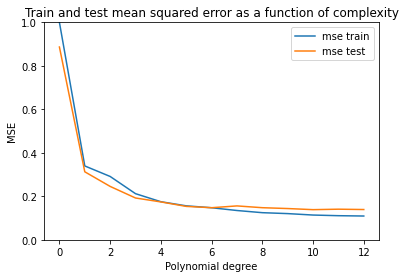

In [18]:
np.random.seed(870) #comment out if one wants to generate different random noise each run
    
N = 20 #data size
x, y = makeData(N)


z = FrankeFunction(x, y)
z = noiseGeneration(z,0.1)
scale_data = True # performing scaling True if yes, False if no
#creating lists
R2_test = []
R2_train = []



numOfPoly_index = []
beta_index = []
numOfPoly_max = input("What is your desired polynomial max degree?:")
numOfPoly_max = int(numOfPoly_max) 

MSE_test = np.zeros(numOfPoly_max + 1 )
MSE_train = np.zeros(numOfPoly_max + 1)

#for loop for number of polynomials
for poly in range(numOfPoly_max +1):
    
    
    X = X_generator(x,y, poly)

    

    X_train, X_test, z_train, z_test = traningDataGenerator(X,z)
    if poly>0:
        X = np.delete(X,0,1)
    X_train, X_test, z_train, z_test = scale(X_train, X_test,z_train,z_test)
        #X_train[:,0] = X_train[:,0] +1 #do this to fix intercept
        #X_test[:,0] = X_test[:,0] +1 #do this to fit intercept
        

    
    # matrix inversion to find beta
    z_offset = np.mean(z_train,axis = 0)
    beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train

    # and then make the prediction
    ytilde = X_train @ beta + z_offset

    ypredict = X_test @ beta + z_offset
    

    R2_test.append(R2(z_test,ypredict))

    R2_train.append(R2(z_train,ytilde))

    MSE_train[poly] = MSE(z_train,ytilde)

    MSE_test[poly] = MSE(z_test,ypredict)

    numOfPoly_index.append(poly)
    beta_index.append(beta)

    #Printing each itteration
    print('Degree: %i   mse train: %.6f   mse test: %.6f'\
        %(poly, MSE_train[poly], MSE_test[poly]))
    
plt.plot(numOfPoly_index, MSE_train, label='mse train')
plt.plot(numOfPoly_index, MSE_test, label='mse test')

plt.legend()
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.ylim(0,1)
plt.title("Train and test mean squared error as a function of complexity")
plt.show()
 

# Finding optimal Lambda for ridge and Lasso regression for a given polynomial

Best lambda value for Lasso: 0.0001
Best lambda value for Ridge: 0.0001


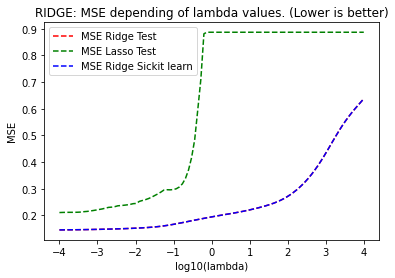

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [41]:
np.random.seed(870) # For comparing runs and changes
numOfPoly_max = 10
N = 20 #data size
x, y = makeData(N)
poly_degree = int((numOfPoly_max+1)*(numOfPoly_max+2)/2)
numberOfLambdas = 100 #number of lamdas

lambdas = np.logspace(-4, 4, numberOfLambdas)

MSERidgePredict = np.zeros(numberOfLambdas)
MSELassoPredict = np.zeros(numberOfLambdas)
MSE_Ridge_sklearn = np.zeros(numberOfLambdas)
I = np.eye(poly_degree - 1 ,poly_degree - 1) #need to fix dimensions
RidgeBestLambdaIndex = 0 #default value
LassoBestLambdaIndex = 0 #default value

X = X_generator(x,y,numOfPoly_max)
X = np.delete(X,0,1)
X_train, X_test, z_train, z_test = traningDataGenerator(X,z)
X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
z_intercept = np.mean(z_train,axis = 0)
for i in range(numberOfLambdas):
    lmb = lambdas[i]
    Ridge_beta = np.linalg.pinv(X_train.T @ X_train + lmb*I) @ X_train.T @ z_train
    Ridge_model = linear_model.Ridge(lmb,fit_intercept = True)
    Ridge_model.fit(X_train,z_train)
    z_pred_ridge_s = Ridge_model.predict(X_test)
    # and then make the prediction
    
    ypredictRidge = X_test @ Ridge_beta  + z_intercept
    MSERidgePredict[i] = MSE(z_test,ypredictRidge)
    RegLasso = linear_model.Lasso(lmb,max_iter=1e5, tol=0.1,fit_intercept=True)
    
    RegLasso.fit(X_train,z_train)
    ypredictLasso = RegLasso.predict(X_test)
    
    MSELassoPredict[i] = MSE(z_test,ypredictLasso)
    MSE_Ridge_sklearn[i] = MSE(z_test,z_pred_ridge_s)
    if i==0:
        RidgeBestLambdaIndex = 0
        LassoBestLambdaIndex = 0
        
    else :
        if MSERidgePredict[i] < MSERidgePredict[RidgeBestLambdaIndex] :
            RidgeBestLambdaIndex = i
        if MSELassoPredict[i] < MSELassoPredict[LassoBestLambdaIndex] :
            LassoBestLambdaIndex = i
            
print('Best lambda value for Lasso:', lambdas[LassoBestLambdaIndex])
print('Best lambda value for Ridge:',lambdas[RidgeBestLambdaIndex])

plt.figure()
plt.plot(np.log10(lambdas), MSERidgePredict, 'r--', label = 'MSE Ridge Test')
plt.plot(np.log10(lambdas), MSELassoPredict, 'g--', label = 'MSE Lasso Test')
plt.plot(np.log10(lambdas), MSE_Ridge_sklearn, 'b--', label = 'MSE Ridge Sickit learn')
plt.title("RIDGE: MSE depending of lambda values. (Lower is better)")
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()
plt.figure()

For polynomial 10 the best lambda value is set to approximately 0.1

# Finding best lambdas for a range of polynomials, up until  poly degree 12

What is your desired polynomial max degree?:12


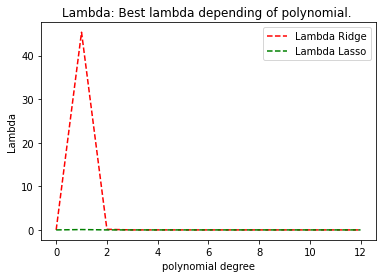

<Figure size 432x288 with 0 Axes>

In [33]:
np.random.seed(870) #comment out if one wants to generate different random noise each run
    
N = 20 #data size
x_flat, y_flat = makeData(N)


z = FrankeFunction(x_flat, y_flat)
z = noiseGeneration(z,0.1)



numOfPoly_index = []
beta_index = []

numOfPoly_max = input("What is your desired polynomial max degree?:")
numOfPoly_max = int(numOfPoly_max) 

best_lambda_ridge = [None] * (numOfPoly_max +1)
best_lambda_lasso = [None] * (numOfPoly_max +1)
for poly in range(numOfPoly_max +1):
    
    X = X_generator(x_flat,y_flat, poly)
    if poly>0:
        X = np.delete(X,0,1)
    X_train, X_test, z_train, z_test = traningDataGenerator(X,z)
    
    
    X_train, X_test,z_train, z_test = scale(X_train, X_test, z_train, z_test)
        
    best_lambda_lasso[poly],best_lambda_ridge[poly] = RidgeAndLasso(X_train,z_train,X_test,z_test,poly)   

plt.figure()
plt.plot(best_lambda_ridge, 'r--', label = 'Lambda Ridge')
plt.plot(best_lambda_lasso , 'g--', label = 'Lambda Lasso')
plt.title("Lambda: Best lambda depending of polynomial. ")
plt.xlabel('polynomial degree')
plt.ylabel('Lambda')
plt.legend()
plt.show()
plt.figure()
df_lambdas= pd.DataFrame({"Lasso_lambda":best_lambda_lasso,"Ridge_lambda":best_lambda_ridge})

In [40]:
print(df_lambdas.to_latex(index=True))

\begin{tabular}{lrr}
\toprule
{} &  Lasso\_lambda &  Ridge\_lambda \\
\midrule
0  &      0.000100 &      0.000100 \\
1  &      0.081113 &     45.348785 \\
2  &      0.001630 &      0.141747 \\
3  &      0.000100 &      0.000100 \\
4  &      0.000100 &      0.005995 \\
5  &      0.000100 &      0.000100 \\
6  &      0.000534 &      0.000100 \\
7  &      0.000774 &      0.000100 \\
8  &      0.000368 &      0.000100 \\
9  &      0.000305 &      0.000100 \\
10 &      0.000305 &      0.000100 \\
11 &      0.000368 &      0.000100 \\
12 &      0.000534 &      0.000100 \\
\bottomrule
\end{tabular}



Unsuprisingly on the vanilla data sett there is almost lambda = 0 witch would give the best fit, this is interpreted as OLS or close to OLS should be the best fit.

# Computing the Bias variance tradeoff for OLS,Ridge and Lasso.

What is your desired polynomial max degree?:12
Degree: 0   mse: 0.889927   bias: 0.887159  variance: 0.002768
Degree: 1   mse: 0.316316   bias: 0.312284  variance: 0.004032
Degree: 2   mse: 0.251269   bias: 0.244303  variance: 0.006965
Degree: 3   mse: 0.201287   bias: 0.192935  variance: 0.008353
Degree: 4   mse: 0.198027   bias: 0.182475  variance: 0.015552
Degree: 5   mse: 0.167989   bias: 0.153176  variance: 0.014813
Degree: 6   mse: 0.193589   bias: 0.151218  variance: 0.042371
Degree: 7   mse: 0.194579   bias: 0.154970  variance: 0.039610
Degree: 8   mse: 0.199112   bias: 0.136107  variance: 0.063005
Degree: 9   mse: 0.224623   bias: 0.134658  variance: 0.089965
Degree: 10   mse: 0.653433   bias: 0.137357  variance: 0.516076
Degree: 11   mse: 0.657368   bias: 0.172691  variance: 0.484677
Degree: 12   mse: 0.703545   bias: 0.155713  variance: 0.547832


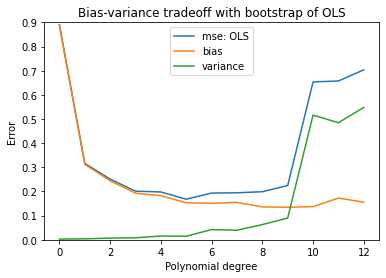

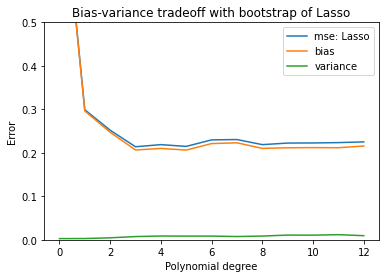

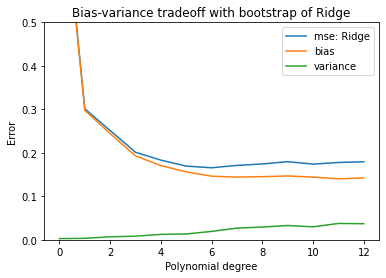

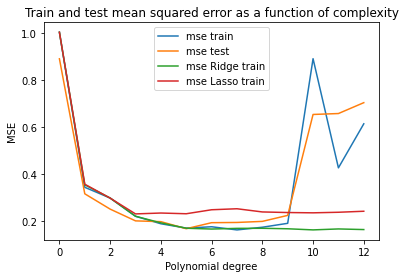

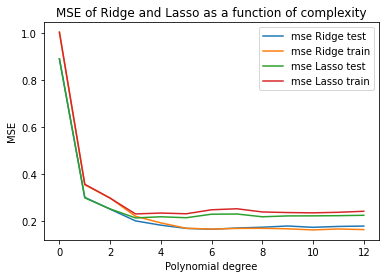

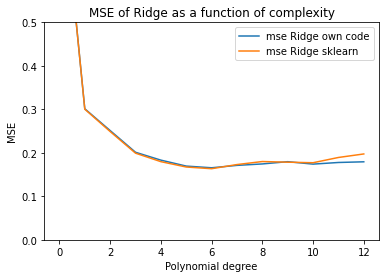

In [42]:
np.random.seed(870) #comment out if one wants to generate different random noise each run
    
N = 20 #data size
x_flat, y_flat = makeData(N)


z = FrankeFunction(x_flat, y_flat)
z = noiseGeneration(z,0.1)
scale_data = True # performing scaling True if yes, False if no
#creating lists
R2_test = []
R2_train = []

n_bootstraps = 100



numOfPoly_max = input("What is your desired polynomial max degree?:")
numOfPoly_max = int(numOfPoly_max) 

numOfPoly_index = np.zeros(numOfPoly_max + 1)
#bias varaiaance and mse
MSE_list = np.zeros(numOfPoly_max + 1 )
MSE_list_ridge = np.zeros(numOfPoly_max + 1 )
MSE_list_lasso = np.zeros(numOfPoly_max + 1 )
bias = np.zeros(numOfPoly_max + 1)
bias_ridge = np.zeros(numOfPoly_max + 1)
bias_lasso = np.zeros(numOfPoly_max + 1)
variance = np.zeros(numOfPoly_max + 1)
variance_ridge = np.zeros(numOfPoly_max + 1)
variance_lasso = np.zeros(numOfPoly_max + 1)
MSE_train = np.zeros(numOfPoly_max +1)
MSE_train_ridge = np.zeros(numOfPoly_max +1)
MSE_list_ridge_s = np.zeros(numOfPoly_max + 1) # The notation s is for sickit learn
MSE_train_lasso = np.zeros(numOfPoly_max +1)
lmb_ridge = best_lambda_ridge 
lmb_lasso = best_lambda_lasso
#for loop for number of polynomials
for poly in range(numOfPoly_max +1):
    
    i = poly
    X = X_generator(x_flat,y_flat, poly)
    
    if poly > 0: # Remove the intercept colum from the 
        X = np.delete(X,0,1)
    
    X_train, X_test, z_train, z_test = traningDataGenerator(X,z)
    poly_degree = int((poly+1)*(poly+2)/2) # Trenger en forklaring
    
    I = np.eye(poly_degree,poly_degree) 
    if poly > 0: # Fjerner intercept kolonnenn og første rad fra identitess matrisa For scaling
        I = np.eye(poly_degree-1,poly_degree-1)
        
    
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

        
    #    
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_ridge = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_lasso = np.empty((z_test.shape[0], n_bootstraps))
    z_tilde = np.empty((z_train.shape[0], n_bootstraps))
    z_tilde_ridge = np.empty((z_train.shape[0], n_bootstraps))
    z_tilde_lasso = np.empty((z_train.shape[0], n_bootstraps))
    z_pred_ridge_s = np.empty((z_test.shape[0], n_bootstraps))
    for j in range(n_bootstraps):
        #Resampling data
        x_bs,z_bs = resample(X_train, z_train)
        
        #Caluclating the parameters beta for OLS and Ridge
        beta_ols = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        beta_ridge = np.linalg.pinv(x_bs.T @ x_bs + lmb_ridge[i] * I) @ x_bs.T @ z_bs
        
        #Making predictions
        z_pred[:,j] = X_test @ beta_ols + np.mean(z_bs,axis = 0)
        z_tilde[:,j] = X_train @ beta_ols + np.mean(z_bs, axis = 0)
        z_pred_ridge[:,j] = X_test @ beta_ridge + np.mean(z_bs, axis = 0)
        
        z_tilde_ridge[:,j] = X_train @ beta_ridge + np.mean(z_bs, axis = 0)
        
        #validating that right usage of sickit learn
        Ridge_model = linear_model.Ridge(lmb_ridge[i],fit_intercept = True)
        Ridge_model.fit(x_bs,z_bs)
        z_pred_ridge_s[:,j] = Ridge_model.predict(X_test)
        
        #Same for lasso
        RegLasso = linear_model.Lasso(lmb_lasso[i],max_iter=1e5, tol=0.1,fit_intercept = True)
        RegLasso.fit(x_bs,z_bs)
        z_pred_lasso[:,j] = RegLasso.predict(X_test)
        z_tilde_lasso[:,j] = RegLasso.predict(X_train)
    
    #Computing Score lists, for analysing bias variance trade off
    #MSE`s
    MSE_list[poly] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred)**2, axis=1, keepdims=True))
    MSE_list_ridge[poly] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ridge)**2, axis=1, keepdims=True))
    MSE_list_lasso[poly] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_lasso)**2, axis=1, keepdims=True))
    MSE_list_ridge_s[poly] =  np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ridge_s)**2, axis=1, keepdims=True))
    
    #Biases
    bias[poly] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred, axis=1, keepdims=True))**2)
    bias_ridge[poly] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ridge, axis=1, keepdims=True))**2)
    bias_lasso[poly] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_lasso, axis=1, keepdims=True))**2)
    
    #Variances
    variance[poly] = np.mean(np.var(z_pred, axis=1, keepdims=True))
    variance_ridge[poly] = np.mean(np.var(z_pred_ridge, axis=1, keepdims=True))
    variance_lasso[poly] = np.mean(np.var(z_pred_lasso, axis=1, keepdims=True))
    
    #Training MSES
    MSE_train[poly] = np.mean(np.mean((z_train.reshape(-1,1) - z_tilde)**2, axis=1, keepdims=True))
    MSE_train_ridge[poly] = np.mean(np.mean((z_train.reshape(-1,1) - z_tilde_ridge)**2, axis=1, keepdims=True))
    MSE_train_lasso[poly] = np.mean(np.mean((z_train.reshape(-1,1) - z_tilde_lasso)**2, axis=1, keepdims=True))
    numOfPoly_index[poly] = poly


    #Printing each itteration
    print('Degree: %i   mse: %.6f   bias: %.6f  variance: %.6f'\
        %(poly, MSE_list[poly], bias[poly], variance[poly]))
    
#Plotting
plt.plot(numOfPoly_index, MSE_list, label='mse: OLS')
plt.plot(numOfPoly_index, bias, label='bias')
plt.plot(numOfPoly_index, variance, label='variance')
plt.title("Bias-variance tradeoff with bootstrap of OLS")
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
plt.ylim(0,0.9)
plt.legend()
plt.show()

plt.plot(numOfPoly_index, MSE_list_lasso, label='mse: Lasso')
plt.plot(numOfPoly_index, bias_lasso, label='bias')
plt.plot(numOfPoly_index, variance_lasso, label='variance')
plt.title("Bias-variance tradeoff with bootstrap of Lasso")
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
plt.ylim(0,0.5)
plt.legend()
plt.show()

plt.plot(numOfPoly_index, MSE_list_ridge, label='mse: Ridge')
plt.plot(numOfPoly_index, bias_ridge, label='bias')
plt.plot(numOfPoly_index, variance_ridge, label='variance')
plt.title("Bias-variance tradeoff with bootstrap of Ridge")
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
plt.ylim(0,0.5)
plt.legend()
plt.show()


plt.plot(numOfPoly_index, MSE_train, label='mse train')
plt.plot(numOfPoly_index, MSE_list, label='mse test')
plt.plot(numOfPoly_index, MSE_train_ridge, label='mse Ridge train')
plt.plot(numOfPoly_index, MSE_train_lasso, label='mse Lasso train')
plt.legend()
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("Train and test mean squared error as a function of complexity")
plt.show()

plt.plot(numOfPoly_index, MSE_list_ridge, label='mse Ridge test')
plt.plot(numOfPoly_index, MSE_train_ridge, label='mse Ridge train')
plt.plot(numOfPoly_index, MSE_list_lasso, label='mse Lasso test')
plt.plot(numOfPoly_index, MSE_train_lasso, label='mse Lasso train')
plt.legend()
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("MSE of Ridge and Lasso as a function of complexity")
plt.show()

plt.plot(numOfPoly_index, MSE_list_ridge, label='mse Ridge own code')
plt.plot(numOfPoly_index, MSE_list_ridge_s, label='mse Ridge sklearn')
plt.legend()
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.ylim(0,0.5)
plt.title("MSE of Ridge as a function of complexity")
plt.show()

df_bootstrap = pd.DataFrame({"MSE_OLS":MSE_list,"MSE_Ridge":MSE_list_ridge,"MSE_Lasso":MSE_list_lasso,\
                  "Bias_OLS":bias,"Bias_Ridge":bias_ridge,"Bias_Lasso":bias_lasso,\
                  "Var_OLS":variance,"Var_Ridge":variance_ridge,"Var_Lasso":variance_lasso})
df_bootstrap.index.name = "polynomial degree"
 

#Printing out the data frame table

In [50]:
df_bootstrap
print(df_bootstrap.to_latex(index=False))

\begin{tabular}{rrrrrrrrr}
\toprule
 MSE\_OLS &  MSE\_Ridge &  MSE\_Lasso &  Bias\_OLS &  Bias\_Ridge &  Bias\_Lasso &  Var\_OLS &  Var\_Ridge &  Var\_Lasso \\
0.889927 &   0.889927 &   0.889927 &  0.887159 &    0.887159 &    0.887159 & 0.002768 &   0.002768 &   0.002768 \\
\midrule
0.316316 &   0.316316 &   0.315262 &  0.312284 &    0.312284 &    0.312146 & 0.004032 &   0.004032 &   0.003116 \\
0.251269 &   0.251269 &   0.249056 &  0.244303 &    0.244303 &    0.244247 & 0.006965 &   0.006965 &   0.004809 \\
0.201287 &   0.201287 &   0.213961 &  0.192935 &    0.192936 &    0.206513 & 0.008353 &   0.008351 &   0.007448 \\
0.198027 &   0.197369 &   0.218814 &  0.182475 &    0.181940 &    0.210119 & 0.015552 &   0.015429 &   0.008695 \\
0.167989 &   0.169492 &   0.214784 &  0.153176 &    0.156093 &    0.206305 & 0.014813 &   0.013399 &   0.008479 \\
0.193589 &   0.165612 &   0.215212 &  0.151218 &    0.146295 &    0.203707 & 0.042371 &   0.019317 &   0.011505 \\
0.194579 &   0.171126 &   

# Cross validating and comparison of different regression methods fitted to a Franke function

First for the OLS Case and also comparing witch sickit learn 

Test MSE_scaled_cross val of degree0
1.015794733361045
Test MSE_scaled_cross val of degree1
0.35072071931467563
Test MSE_scaled_cross val of degree2
0.299986459560509
Test MSE_scaled_cross val of degree3
0.22642884536667457
Test MSE_scaled_cross val of degree4
0.1943139829284583
Test MSE_scaled_cross val of degree5
0.18153293219604377
Test MSE_scaled_cross val of degree6
0.17972105788459364
Test MSE_scaled_cross val of degree7
0.17397144728505104
Test MSE_scaled_cross val of degree8
0.17898844941162512
Test MSE_scaled_cross val of degree9
0.18448237142136453
Test MSE_scaled_cross val of degree10
0.19556682897224303
Test MSE_scaled_cross val of degree11
0.21601432631450548
Test MSE_scaled_cross val of degree12
0.23165246842621076


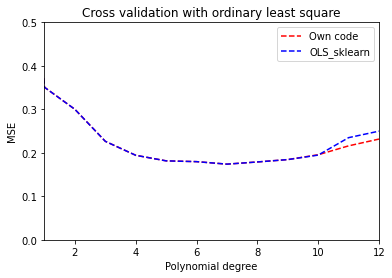

-3.947459643111668e-17


In [42]:
np.random.seed(870)
N = 20 #data size
x_flat, y_flat = makeData(N)


z_in = FrankeFunction(x_flat, y_flat)
z = noiseGeneration(z_in,0.1)

k = 10 #Number of folds
kfold = KFold(n_splits = k, shuffle=True, random_state=22) 

#creating lists


numOfPoly_max = 12



numOfPoly_index = np.zeros(numOfPoly_max + 1)
beta_index = []
beta_index_scaled = []
mse_ols_cross_val = np.zeros(numOfPoly_max + 1)
mse_OLS_cval = np.zeros(numOfPoly_max + 1)
#for loop for number of polynomials
for i in range(0,numOfPoly_max +1 ):
    numOfPoly = i  
    X = X_generator(x_flat,y_flat, numOfPoly)
    if i>0:
        X = np.delete(X,0,1)
    Xs = X_generator(x_flat,y_flat,numOfPoly) # X generator for sklearn
    if i>0:
        Xs = np.delete(Xs,0,1)
    mse_cross_val = np.zeros(k)
    mse_OLS_split = np.zeros(k)
    cv_split = 0
    for train_slice, test_slice in kfold.split(X):
        X_train = X[train_slice]
        X_test = X[test_slice]
        z_train = z[train_slice]
        z_test = z[test_slice]
        
        
        X_train, X_test, z_train,z_test = scale(X_train, X_test, z_train, z_test)
        #X_train[:,0] = 1
        #X_test[:,0] = 1

        z_intercept = np.mean(z_train)
        beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        z_intercept =  np.mean(z_train,axis=0)
        z_predict = X_test @ beta  + z_intercept
        mse_cross_val[cv_split] = MSE(z_test, z_predict)

        cv_split += 1
    cv_split = 0
    #Cheking if Sickit learn will yield he same results
    for train_slice, test_slice in kfold.split(Xs):
        X_train_s = Xs[train_slice]
        X_test_s = Xs[test_slice]
        z_train_s = z[train_slice]
        z_test_s = z[test_slice]
        X_train_s, X_test_s, z_train_s,z_test_s = scale(X_train_s, X_test_s, z_train_s, z_test_s)
        #X_train_s[:,0] = 1
        #X_test_s[:,0] = 1
        OLS_model = linear_model.LinearRegression(fit_intercept = True)
        OLS_model.fit(X_train_s, z_train_s)
        

        z_pred_ols = OLS_model.predict(X_test_s)
        mse_OLS_split[cv_split] = MSE(z_test_s, z_pred_ols)
        cv_split += 1
        
    numOfPoly_index[i] = numOfPoly
    mse_OLS_cval[i] = np.mean(mse_OLS_split) # sickit learn
    mse_ols_cross_val[i] = np.mean(mse_cross_val) #own code
    print("Test MSE_scaled_cross val of degree{}".format(i))
    print(mse_ols_cross_val[i])



    
plt.plot(numOfPoly_index, mse_ols_cross_val,"r--", label = "Own code" ) 
plt.plot(numOfPoly_index, mse_OLS_cval,"b--", label = "OLS_sklearn")
plt.ylim(0,0.5)
plt.xlim(0.99,i)
plt.title("Cross validation with ordinary least square")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Polynomial degree")
plt.show()


#print("Training MSE_scaled")
#print(MSE(y_train,ytilde_scaled))


print(z_intercept)

# Comparing OLS,Ridge and Lasso regression

enter the max degree:12
max degree is : 12
Eureka


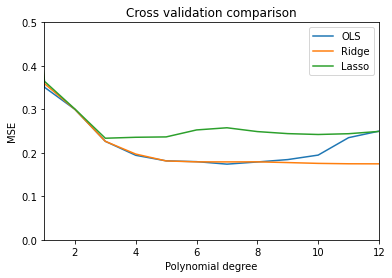

In [36]:
np.random.seed(870)
N = 20 #data size
x_flat, y_flat = makeData(N)


z = FrankeFunction(x_flat, y_flat)
z = noiseGeneration(z,0.1)
max_degree = input("enter the max degree:")
max_degree = int(max_degree)
print("max degree is :",max_degree)


degree_list = np.zeros(max_degree +1)

lmb_ridge = best_lambda_ridge
lmb_lasso = best_lambda_lasso
k = 10 #Number of folds
kfold = KFold(n_splits = k, shuffle=True, random_state=22) 

#Error Lists:
mse_Ridge_cval = np.zeros(max_degree + 1)
mse_OLS_cval = np.zeros(max_degree + 1)
mse_Lasso_cval = np.zeros(max_degree + 1)

for degree in range(0,max_degree + 1):
    degree_list[degree] = degree
    X = X_generator(x_flat,y_flat, degree)
    if degree > 0:
        X = np.delete(X,0,1)
    mse_OLS_split = np.zeros(k)
    mse_Ridge_split = np.zeros(k)
    mse_Lasso_split = np.zeros(k)
    cv_split = 0
    
    
    for train_ind, test_ind in kfold.split(X):
        X_train = X[train_ind]
        X_test = X[test_ind]
        z_train = z[train_ind]
        z_test = z[test_ind]
        
        X_train, X_test, z_train, z_test = scale(X_train, X_test,z_train,z_test)
    
        #Creating models
        OLS_model = linear_model.LinearRegression(fit_intercept = True)
        OLS_model.fit(X_train, z_train)
        
        Ridge_model = linear_model.Ridge(lmb_ridge[degree],fit_intercept = True)
        Ridge_model.fit(X_train,z_train)
    
        Lasso_model = linear_model.Lasso(lmb_lasso[degree],max_iter=1e5, tol=0.1,fit_intercept = True)
        Lasso_model.fit(X_train,z_train)
    
        #Predicting 
        z_pred_ols = OLS_model.predict(X_test)
        z_pred_ridge = Ridge_model.predict(X_test)
        z_pred_lasso = Lasso_model.predict(X_test)
    
        #Calculating MSE for each fold
        mse_OLS_split[cv_split] = mean_squared_error(z_test, z_pred_ols)
        mse_Ridge_split[cv_split] = mean_squared_error(z_test, z_pred_ridge)
        mse_Lasso_split[cv_split] = mean_squared_error(z_test, z_pred_lasso)
        
        cv_split += 1
    
    mse_Ridge_cval[degree] = np.mean(mse_Ridge_split)
    mse_OLS_cval[degree] = np.mean(mse_OLS_split)
    mse_Lasso_cval[degree] = np.mean(mse_Lasso_split)

    
print("Eureka")

data = pd.DataFrame(columns =( ['mse_OLS', 'mse_ridge', 'mse_lasso']))

df_CVal = pd.DataFrame({"mse_cval_OLS":mse_OLS_cval,"mse_cval_Ridge":mse_Ridge_cval,"mse_cval_Lasso":mse_Lasso_cval}, index= degree_list)
df_CVal.index.name = "polynomial degree"
    
    
plt.plot(degree_list, mse_OLS_cval, label = "OLS")
plt.plot(degree_list, mse_Ridge_cval , label = "Ridge")
plt.plot(degree_list, mse_Lasso_cval, label = "Lasso")
plt.legend()
plt.ylim(0,0.5)
plt.xlim(0.99,degree)
plt.title("Cross validation comparison")
plt.ylabel("MSE")
plt.xlabel("Polynomial degree")
plt.show()    






Using Ridge, seems like the slithgest best soulutions , although  the optimal lambda value is infact not 0, but up to polynomial degree of 10 there is 0 difference between ridge and OLS

In [37]:
df_CVal
print(df_CVal.to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
{} &  mse\_cval\_OLS &  mse\_cval\_Ridge &  mse\_cval\_Lasso \\
polynomial degree &               &                 &                 \\
\midrule
0.0               &      1.015795 &        1.015795 &        1.015795 \\
1.0               &      0.350721 &        0.359068 &        0.364345 \\
2.0               &      0.299986 &        0.299980 &        0.300656 \\
3.0               &      0.226429 &        0.226428 &        0.233562 \\
4.0               &      0.194314 &        0.197176 &        0.235754 \\
5.0               &      0.181533 &        0.181340 &        0.236584 \\
6.0               &      0.179721 &        0.179224 &        0.252628 \\
7.0               &      0.173971 &        0.179144 &        0.257609 \\
8.0               &      0.178988 &        0.179271 &        0.248847 \\
9.0               &      0.184461 &        0.177590 &        0.244144 \\
10.0              &      0.194783 &        0.175727 &        0.242163 \\
11.0              & 

# Utelizing same methods on Real data gotten from Kartnorge